In [1]:
!pip install nba_api

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.2/280.2 kB 5.7 MB/s eta 0:00:00


In [3]:
from nba_api.stats.endpoints import leaguegamefinder
import pandas as pd

# Use LeagueGameFinder to fetch historical games
game_finder = leaguegamefinder.LeagueGameFinder()
games = game_finder.get_data_frames()[0]  # Get the first DataFrame

# List of NBA team abbreviations (exclude G League teams)
nba_team_abbreviations = [
    'ATL', 'BOS', 'BKN', 'CHA', 'CHI', 'CLE', 'DAL', 'DEN', 'DET', 'GSW',
    'HOU', 'IND', 'LAC', 'LAL', 'MEM', 'MIA', 'MIL', 'MIN', 'NOP', 'NYK',
    'OKC', 'ORL', 'PHI', 'PHX', 'POR', 'SAC', 'SAS', 'TOR', 'UTA', 'WAS'
]

# Filter out G League games by keeping only NBA team abbreviations
nba_games = games[games['TEAM_ABBREVIATION'].isin(nba_team_abbreviations)]

# Sort games by date (most recent first)
nba_games['GAME_DATE'] = pd.to_datetime(nba_games['GAME_DATE'])
nba_games = nba_games.sort_values(by='GAME_DATE', ascending=False)

# Filter to the last 100 NBA games
last_200_nba_games = nba_games.head(200)

# Save to a CSV file (optional)
last_200_nba_games.to_csv('last_200_nba_games.csv', index=False)

# Display the DataFrame
print(last_200_nba_games.head())

   SEASON_ID     TEAM_ID TEAM_ABBREVIATION               TEAM_NAME  \
0      22024  1610612764               WAS      Washington Wizards   
11     22024  1610612762               UTA               Utah Jazz   
16     22024  1610612750               MIN  Minnesota Timberwolves   
15     22024  1610612763               MEM       Memphis Grizzlies   
12     22024  1610612747               LAL      Los Angeles Lakers   

       GAME_ID  GAME_DATE      MATCHUP WL  MIN  PTS  ...  FT_PCT  OREB  DREB  \
0   0022400674 2025-01-30  WAS vs. LAL  L  240   96  ...   0.824    12    26   
11  0022400677 2025-01-30  UTA vs. MIN  L  240  113  ...   0.840     3    20   
16  0022400677 2025-01-30    MIN @ UTA  W  240  138  ...   0.792     9    30   
15  0022400676 2025-01-30  MEM vs. HOU  W  239  120  ...   0.750     9    28   
12  0022400674 2025-01-30    LAL @ WAS  W  241  134  ...   0.955     9    39   

    REB  AST  STL  BLK  TOV  PF  PLUS_MINUS  
0    38   18    4    6   13  18       -38.0  
11   2

<ipython-input-3-2bf4c58f7bda>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nba_games['GAME_DATE'] = pd.to_datetime(nba_games['GAME_DATE'])


In [4]:
import pandas as pd

# Load the last 100 NBA games (if not already loaded)
last_200_nba_games = pd.read_csv('last_200_nba_games.csv')

# Group by game ID
grouped_games = last_200_nba_games.groupby('GAME_ID')

# Initialize a list to store training data
training_data = []

# Loop through each game
for game_id, game_data in grouped_games:
    # Ensure there are exactly 2 rows (one for each team)
    if len(game_data) != 2:
        continue

    # Extract stats for both teams
    team1 = game_data.iloc[0]
    team2 = game_data.iloc[1]

    # Create composite stats for each team
    team1_stats = {
        'TEAM': team1['TEAM_ABBREVIATION'],
        'REB': team1['REB'],
        'AST': team1['AST'],
        'STL': team1['STL'],
        'BLK': team1['BLK'],
        'TOV': team1['TOV'],
        'FG_PCT': team1['FG_PCT'],
        '3P_PCT': team1['FG3_PCT'],
        'FT_PCT': team1['FT_PCT']
    }

    team2_stats = {
        'TEAM': team2['TEAM_ABBREVIATION'],
        'REB': team2['REB'],
        'AST': team2['AST'],
        'STL': team2['STL'],
        'BLK': team2['BLK'],
        'TOV': team2['TOV'],
        'FG_PCT': team2['FG_PCT'],
        '3P_PCT': team2['FG3_PCT'],
        'FT_PCT': team2['FT_PCT']
    }

    # Determine the game outcome (1 if team1 wins, 0 if team2 wins)
    if team1['WL'] == 'W':
        outcome = 1
    else:
        outcome = 0

    # Combine stats into a single row for training
    training_row = {
        'GAME_ID': game_id,
        'TEAM1': team1_stats['TEAM'],
        'TEAM2': team2_stats['TEAM'],
        'TEAM1_REB': team1_stats['REB'],
        'TEAM2_REB': team2_stats['REB'],
        'TEAM1_AST': team1_stats['AST'],
        'TEAM2_AST': team2_stats['AST'],
        'TEAM1_STL': team1_stats['STL'],
        'TEAM2_STL': team2_stats['STL'],
        'TEAM1_BLK': team1_stats['BLK'],
        'TEAM2_BLK': team2_stats['BLK'],
        'TEAM1_TOV': team1_stats['TOV'],
        'TEAM2_TOV': team2_stats['TOV'],
        'TEAM1_FG_PCT': team1_stats['FG_PCT'],
        'TEAM2_FG_PCT': team2_stats['FG_PCT'],
        'TEAM1_3P_PCT': team1_stats['3P_PCT'],
        'TEAM2_3P_PCT': team2_stats['3P_PCT'],
        'TEAM1_FT_PCT': team1_stats['FT_PCT'],
        'TEAM2_FT_PCT': team2_stats['FT_PCT'],
        'OUTCOME': outcome
    }

    # Append to the training data
    training_data.append(training_row)

# Convert the training data to a DataFrame
training_df = pd.DataFrame(training_data)

# Save to a CSV file (optional)
training_df.to_csv('nba_training_data.csv', index=False)

# Display the DataFrame
print(training_df.head())

    GAME_ID TEAM1 TEAM2  TEAM1_REB  TEAM2_REB  TEAM1_AST  TEAM2_AST  \
0  22400532   HOU   ATL         44         40         19         19   
1  22400578   NYK   MIN         41         46         19         23   
2  22400581   UTA   NOP         40         56         30         34   
3  22400582   MEM   SAS         41         40         39         29   
4  22400583   DAL   OKC         43         46         25         24   

   TEAM1_STL  TEAM2_STL  TEAM1_BLK  TEAM2_BLK  TEAM1_TOV  TEAM2_TOV  \
0         12         11          4          5         21         16   
1         10          5          4          2          9         15   
2          7          9          8          8         15         13   
3          9          4          0          8          7         17   
4         11          7          7          2         17         15   

   TEAM1_FG_PCT  TEAM2_FG_PCT  TEAM1_3P_PCT  TEAM2_3P_PCT  TEAM1_FT_PCT  \
0         0.468         0.404         0.233         0.234         0.950

In [5]:
# Features (X) and labels (y)
X = training_df.drop(columns=['GAME_ID', 'TEAM1', 'TEAM2', 'OUTCOME'])  # Drop non-feature columns
y = training_df['OUTCOME']  # Labels (1 if TEAM1 wins, 0 if TEAM2 wins)

# Check for missing values
print(X.isnull().sum())  # Ensure there are no missing values

# If there are missing values, handle them (e.g., fill with mean)
X = X.fillna(X.mean())

TEAM1_REB       0
TEAM2_REB       0
TEAM1_AST       0
TEAM2_AST       0
TEAM1_STL       0
TEAM2_STL       0
TEAM1_BLK       0
TEAM2_BLK       0
TEAM1_TOV       0
TEAM2_TOV       0
TEAM1_FG_PCT    0
TEAM2_FG_PCT    0
TEAM1_3P_PCT    0
TEAM2_3P_PCT    0
TEAM1_FT_PCT    0
TEAM2_FT_PCT    0
dtype: int64


In [6]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (78, 16)
Testing set size: (20, 16)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96        12
           1       0.89      1.00      0.94         8

    accuracy                           0.95        20
   macro avg       0.94      0.96      0.95        20
weighted avg       0.96      0.95      0.95        20


Confusion Matrix:
[[11  1]
 [ 0  8]]


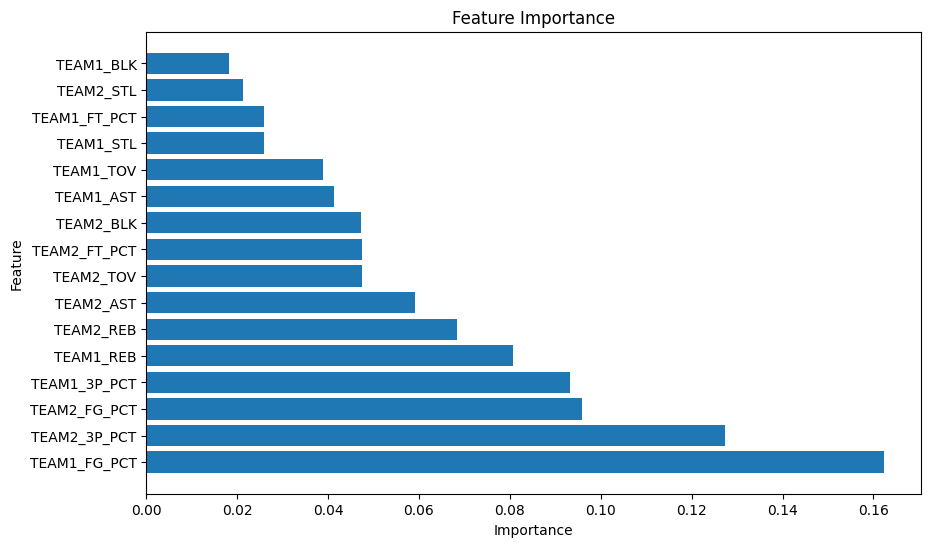

In [8]:
import matplotlib.pyplot as plt

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()

In [9]:
# Example: New game stats (replace with actual data)
new_game_stats = {
    'TEAM1_REB': 45, 'TEAM2_REB': 42,
    'TEAM1_AST': 25, 'TEAM2_AST': 23,
    'TEAM1_STL': 8, 'TEAM2_STL': 7,
    'TEAM1_BLK': 5, 'TEAM2_BLK': 4,
    'TEAM1_TOV': 12, 'TEAM2_TOV': 14,
    'TEAM1_FG_PCT': 0.494, 'TEAM2_FG_PCT': 0.455,
    'TEAM1_3P_PCT': 0.380, 'TEAM2_3P_PCT': 0.350,
    'TEAM1_FT_PCT': 0.800, 'TEAM2_FT_PCT': 0.750
}

# Convert to DataFrame
new_game_df = pd.DataFrame([new_game_stats])

# Make prediction
prediction = model.predict_proba(new_game_df)
print(f"Probability of TEAM1 winning: {prediction[0][1]:.2f}")
print(f"Probability of TEAM2 winning: {prediction[0][0]:.2f}")

Probability of TEAM1 winning: 0.91
Probability of TEAM2 winning: 0.09


In [10]:
import joblib

# Save the model
joblib.dump(model, 'nba_game_predictor.pkl')

# Load the model (in the future)
# model = joblib.load('nba_game_predictor.pkl')

['nba_game_predictor.pkl']

In [11]:
!pip install nba_api
from nba_api.live.nba.endpoints import scoreboard

# Fetch upcoming games
scoreboard_data = scoreboard.ScoreBoard()
upcoming_games = scoreboard_data.games.get_dict()

# Display upcoming games
for game in upcoming_games:
    home_team = game['homeTeam']['teamName']
    away_team = game['awayTeam']['teamName']
    game_time = game['gameTimeUTC']
    print(f"{away_team} @ {home_team} - {game_time}")

Clippers @ Hornets - 2025-02-01T00:00:00Z
Mavericks @ Pistons - 2025-02-01T00:00:00Z
Nuggets @ 76ers - 2025-02-01T00:30:00Z
Bulls @ Raptors - 2025-02-01T00:30:00Z
Celtics @ Pelicans - 2025-02-01T01:00:00Z
Bucks @ Spurs - 2025-02-01T01:00:00Z
Suns @ Warriors - 2025-02-01T03:00:00Z


In [12]:
# RUN THIS FOR SEASON AVG

from nba_api.stats.endpoints import leaguedashteamstats
from nba_api.stats.static import teams
import pandas as pd

# Fetch current season team stats
team_stats = leaguedashteamstats.LeagueDashTeamStats(season='2024-25', timeout=30).get_data_frames()[0]

# Get all NBA teams
nba_teams = teams.get_teams()

# Map team IDs to team names
team_id_to_name = {team['id']: team['full_name'].split()[-1] for team in nba_teams}

# Extract relevant stats for each team and calculate per-game averages
team_avg_stats = {}
for _, row in team_stats.iterrows():
    team_id = row['TEAM_ID']
    team_name = team_id_to_name.get(team_id, f"Unknown Team {team_id}")
    games_played = row['GP']  # Number of games played

    # Calculate per-game averages
    team_avg_stats[team_name] = {
        'REB': row['REB'] / games_played,
        'AST': row['AST'] / games_played,
        'STL': row['STL'] / games_played,
        'BLK': row['BLK'] / games_played,
        'TOV': row['TOV'] / games_played,
        'FG_PCT': row['FG_PCT'],  # FG% is already a percentage, no need to divide
        'FG3_PCT': row['FG3_PCT'],  # 3P% is already a percentage, no need to divide
        'FT_PCT': row['FT_PCT']  # FT% is already a percentage, no need to divide
    }

# Display team average stats
for team, stats in team_avg_stats.items():
    print(f"{team}: {stats}")

Hawks: {'REB': 45.1875, 'AST': 28.979166666666668, 'STL': 10.4375, 'BLK': 5.125, 'TOV': 16.25, 'FG_PCT': 0.458, 'FG3_PCT': 0.343, 'FT_PCT': 0.775}
Celtics: {'REB': 45.020833333333336, 'AST': 25.583333333333332, 'STL': 7.520833333333333, 'BLK': 5.625, 'TOV': 11.770833333333334, 'FG_PCT': 0.457, 'FG3_PCT': 0.365, 'FT_PCT': 0.794}
Nets: {'REB': 40.416666666666664, 'AST': 24.854166666666668, 'STL': 7.458333333333333, 'BLK': 3.8333333333333335, 'TOV': 15.604166666666666, 'FG_PCT': 0.44, 'FG3_PCT': 0.353, 'FT_PCT': 0.797}
Hornets: {'REB': 45.93181818181818, 'AST': 23.84090909090909, 'STL': 8.227272727272727, 'BLK': 4.886363636363637, 'TOV': 15.863636363636363, 'FG_PCT': 0.429, 'FG3_PCT': 0.345, 'FT_PCT': 0.773}
Bulls: {'REB': 45.854166666666664, 'AST': 29.0, 'STL': 7.520833333333333, 'BLK': 4.75, 'TOV': 15.104166666666666, 'FG_PCT': 0.465, 'FG3_PCT': 0.371, 'FT_PCT': 0.798}
Cavaliers: {'REB': 44.270833333333336, 'AST': 29.083333333333332, 'STL': 8.375, 'BLK': 4.4375, 'TOV': 12.83333333333333

In [51]:
# RUN THIS FOR LAST 15 GAMES AVG

from nba_api.stats.endpoints import teamgamelog
from nba_api.stats.static import teams
import pandas as pd

# Get all NBA teams
nba_teams = teams.get_teams()

# Initialize a dictionary to store team stats
team_last_15_stats = {}

# Fetch game logs and calculate last 15 games' averages
for team in nba_teams:
    team_id = team['id']
    team_name = team['full_name'].split()[-1]  # Extract team name (e.g., "Celtics")

    try:
        # Fetch the team's game log
        game_log = teamgamelog.TeamGameLog(team_id=team_id, season='2024-25').get_data_frames()[0]

        # Ensure the games are sorted by date (most recent first)
        game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
        game_log = game_log.sort_values(by='GAME_DATE', ascending=False)

        # Get the last 15 games
        last_15_games = game_log.head(15)

        # Calculate average stats for the last 15 games
        team_last_15_stats[team_name] = {
            'REB': last_15_games['REB'].mean(),
            'AST': last_15_games['AST'].mean(),
            'STL': last_15_games['STL'].mean(),
            'BLK': last_15_games['BLK'].mean(),
            'TOV': last_15_games['TOV'].mean(),
            'FG_PCT': last_15_games['FG_PCT'].mean(),
            'FG3_PCT': last_15_games['FG3_PCT'].mean(),
            'FT_PCT': last_15_games['FT_PCT'].mean()
        }
        print(f"Processed stats for {team_name}")
    except Exception as e:
        print(f"Error fetching stats for {team_name}: {e}")

# Display the last 15 games' averages
for team, stats in team_last_15_stats.items():
    print(f"{team}: {stats}")

<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Hawks
Processed stats for Celtics


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Cavaliers
Processed stats for Pelicans


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Bulls
Processed stats for Mavericks


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Nuggets


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Warriors
Processed stats for Rockets


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Clippers
Processed stats for Lakers


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Heat
Processed stats for Bucks


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Timberwolves
Processed stats for Nets


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Knicks
Processed stats for Magic


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Pacers
Processed stats for 76ers


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Suns
Error fetching stats for Blazers: HTTPSConnectionPool(host='stats.nba.com', port=443): Read timed out. (read timeout=30)


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Kings
Processed stats for Spurs


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Thunder
Processed stats for Raptors


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Jazz
Processed stats for Grizzlies


<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])
<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


Processed stats for Wizards
Processed stats for Pistons
Processed stats for Hornets
Hawks: {'REB': 43.733333333333334, 'AST': 27.133333333333333, 'STL': 10.533333333333333, 'BLK': 4.6, 'TOV': 14.8, 'FG_PCT': 0.43753333333333344, 'FG3_PCT': 0.31966666666666665, 'FT_PCT': 0.7550666666666668}
Celtics: {'REB': 43.93333333333333, 'AST': 25.333333333333332, 'STL': 7.2, 'BLK': 5.733333333333333, 'TOV': 11.0, 'FG_PCT': 0.4518666666666667, 'FG3_PCT': 0.3591333333333333, 'FT_PCT': 0.7917333333333333}
Cavaliers: {'REB': 45.266666666666666, 'AST': 29.533333333333335, 'STL': 6.866666666666666, 'BLK': 3.933333333333333, 'TOV': 11.666666666666666, 'FG_PCT': 0.48646666666666655, 'FG3_PCT': 0.3584666666666667, 'FT_PCT': 0.7962666666666667}
Pelicans: {'REB': 42.8, 'AST': 27.0, 'STL': 9.2, 'BLK': 6.266666666666667, 'TOV': 11.4, 'FG_PCT': 0.4576666666666666, 'FG3_PCT': 0.3589333333333334, 'FT_PCT': 0.7736666666666667}
Bulls: {'REB': 47.2, 'AST': 28.0, 'STL': 7.733333333333333, 'BLK': 5.0, 'TOV': 14.4, 'FG

<ipython-input-51-fa74ade4d76e>:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  game_log['GAME_DATE'] = pd.to_datetime(game_log['GAME_DATE'])


In [13]:
import pickle

# Load team_avg_stats from the file
with open('team_avg_stats.pkl', 'rb') as f:
    team_avg_stats = pickle.load(f)

# Display the loaded data
print("Loaded team_avg_stats:")
for team, stats in team_avg_stats.items():
    print(f"{team}: {stats}")

FileNotFoundError: [Errno 2] No such file or directory: 'team_avg_stats.pkl'

In [75]:
import pandas as pd

# Display upcoming games
counter = 0
for game in upcoming_games:
    home_team = game['homeTeam']['teamName']
    away_team = game['awayTeam']['teamName']
    print(f"{counter}. {away_team} @ {home_team}")
    counter += 1

# Example: Prepare data for an upcoming game
upcoming_game = upcoming_games[5]  # First upcoming game
home_team = upcoming_game['homeTeam']['teamName']
away_team = upcoming_game['awayTeam']['teamName']

# Get average stats for both teams
home_stats = team_last_15_stats[home_team]
away_stats = team_last_15_stats[away_team]

# Create a row of features
game_features = {
    'TEAM1_REB': home_stats['REB'], 'TEAM2_REB': away_stats['REB'],
    'TEAM1_AST': home_stats['AST'], 'TEAM2_AST': away_stats['AST'],
    'TEAM1_STL': home_stats['STL'], 'TEAM2_STL': away_stats['STL'],
    'TEAM1_BLK': home_stats['BLK'], 'TEAM2_BLK': away_stats['BLK'],
    'TEAM1_TOV': home_stats['TOV'], 'TEAM2_TOV': away_stats['TOV'],
    'TEAM1_FG_PCT': home_stats['FG_PCT'], 'TEAM2_FG_PCT': away_stats['FG_PCT'],
    'TEAM1_3P_PCT': home_stats['FG3_PCT'], 'TEAM2_3P_PCT': away_stats['FG3_PCT'],
    'TEAM1_FT_PCT': home_stats['FT_PCT'], 'TEAM2_FT_PCT': away_stats['FT_PCT']
}

# Convert to DataFrame
game_df = pd.DataFrame([game_features])

# Load the trained model (if not already loaded)
import joblib
model = joblib.load('nba_game_predictor.pkl')

# Make prediction
prediction = model.predict_proba(game_df)
print(f"Probability of {home_team} winning: {prediction[0][1]:.2f}")
print(f"Probability of {away_team} winning: {prediction[0][0]:.2f}")

0. Clippers @ Hornets
1. Mavericks @ Pistons
2. Nuggets @ 76ers
3. Bulls @ Raptors
4. Celtics @ Pelicans
5. Bucks @ Spurs
6. Suns @ Warriors
Probability of Spurs winning: 0.56
Probability of Bucks winning: 0.44


In [16]:
# TOOL: AMERICAN ODDS TO %
def odds_to_probability(odds):
    if odds > 0:
        probability = 100 / (odds + 100)
    else:
        probability = -odds / (-odds + 100)
    return probability

# Example usage
positive_odds = 170
negative_odds = -205

positive_probability = odds_to_probability(positive_odds)
negative_probability = odds_to_probability(negative_odds)

print(f"Probability for + odds: {positive_probability:.4f} or {positive_probability*100:.2f}%")
print(f"Probability for - odds: {negative_probability:.4f} or {negative_probability*100:.2f}%")

Probability for + odds: 0.3704 or 37.04%
Probability for - odds: 0.6721 or 67.21%


In [ ]:
# TOOL: % TO AMERICAN ODDS
def probability_to_american_odds(probability):
    """Convert a probability to American odds format."""
    if probability < 0 or probability > 1:
        raise ValueError("Probability must be between 0 and 1.")

    if probability < 0.5:
        odds = (100 / probability) - 100
        return f"+{int(round(odds))}"
    else:
        odds = (probability / (1 - probability)) * 100
        return f"-{int(round(odds))}"

# Example usage
probability = 0.37
american_odds = probability_to_american_odds(probability)
print(f"American Odds: {american_odds}")
probability = 0.63
american_odds = probability_to_american_odds(probability)
print(f"American Odds: {american_odds}")

American Odds: +170
American Odds: -170


In [ ]:
import pickle

# Save team_avg_stats to a file using pickle
with open('team_avg_stats.pkl', 'wb') as f:
    pickle.dump(team_avg_stats, f)

print("team_avg_stats saved to 'team_avg_stats.pkl'")

team_avg_stats saved to 'team_avg_stats.pkl'
